In [3]:
import matplotlib.pyplot as plt
import numpy as np

def csf_barten_frequency(f,L,X=40):
    '''
    Implements simplified CSF from Peter Barten,"Formula for the contrast sensitivity of the human eye", Electronic Imaging 2004
    '''
    
    num = 5200*np.exp(-0.0016*(f**2)*((1+100/L)**0.08))
    denom1 = 1+144/X**2+0.64*f**2
    denom21 = 63/L**0.83
    denom22 = 1/(1e-4+1-np.exp(-0.02*(f**2)))
    denom2 =denom21+denom22 
    csf_freq = num/(np.sqrt(denom1*denom2))
    return csf_freq

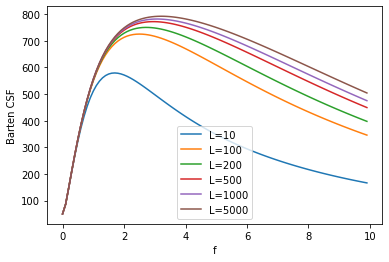

In [11]:
f = np.arange(0,10,0.1)
bart = []
L = [10,100,200,500,1000,5000]
for ls in L:
    bart.append(csf_barten_frequency(f,ls,X=40))
for i in range(len(L)):
    plt.plot(f,bart[i],label="L="+str(L[i]))
plt.legend()
plt.xlabel('f')
plt.ylabel('Barten CSF')
plt.show()

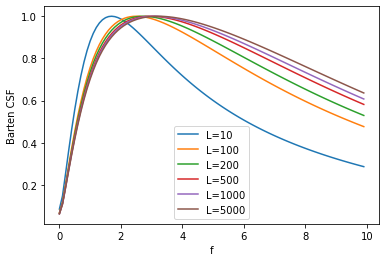

In [12]:
for i in range(len(L)):
    plt.plot(f,bart[i]/np.amax(bart[i]),label="L="+str(L[i]))
plt.xlabel('f')
plt.ylabel('Barten CSF')
plt.legend()
plt.show()